In [ ]:
# Project Title
 # Generative AI–Powered Early Warning System for Tsunami Prediction Across the Gulf Coast and UAE

In [ ]:
# Install required libraries
!pip install obspy transformers torch torchvision torchaudio scikit-learn matplotlib seaborn

In [ ]:
#pandas & numpy → Data handling & math.
#torch & nn → Deep learning / PINN model.
#matplotlib & seaborn → Visualizations.
#MinMaxScaler → Normalize inputs for AI model.
#transformers → Leverage pretrained AI models (like text/NLP).
#obspy → Work with seismic waveform datasets.


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from transformers import pipeline
from obspy import read  # For seismic waveform data


In [ ]:
# Data Preprocessing (Time-Series + Satellite)
# Load & Preprocess Raw Seismic + Ocean Data
# Synthetic seismic waveform (replace with real dataset later)
#Using ObsPy’s read() to load a demo seismic waveform file.
#st = “Stream” object = a collection of seismic traces.

st = read()                          # loads demo seismograph data from obspy
tr = st[0]
seismic_signal = tr.data[:5000]      # take first 5000 points for demo


# Normalization step using MinMaxScaler:
#Normalize seismic data
scaler = MinMaxScaler()
seismic_norm = scaler.fit_transform(seismic_signal.reshape(-1,1))


# Simulated buoy data (replace with NOAA dataset)
buoy = pd.DataFrame({
    "time": np.arange(0, 5000),
    "wave_height": np.sin(np.arange(0,5000)/200) + np.random.normal(0,0.1,5000)
})
buoy["wave_height_norm"] = scaler.fit_transform(buoy[["wave_height"]])



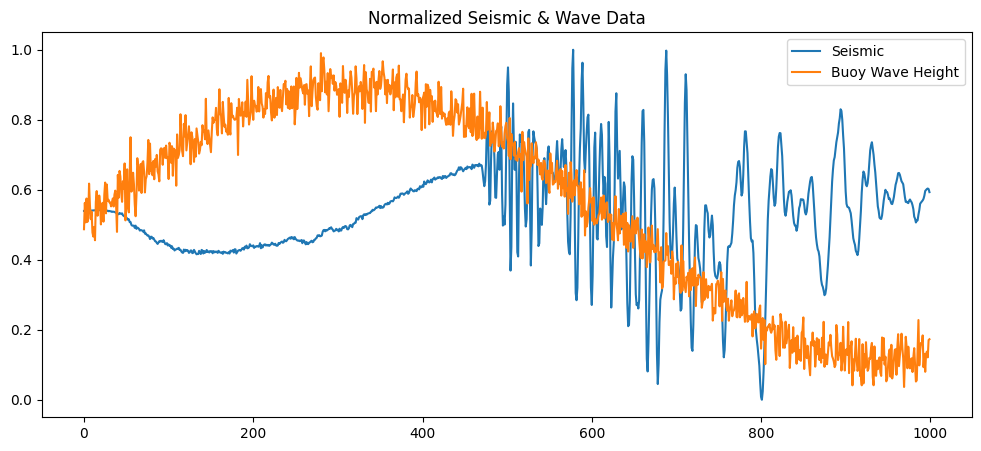

In [ ]:
# Plot sample signals
plt.figure(figsize=(12,5))
plt.plot(seismic_norm[:1000], label="Seismic")
plt.plot(buoy["wave_height_norm"][:1000], label="Buoy Wave Height")
plt.legend()
plt.title("Normalized Seismic & Wave Data")
plt.show()

In [ ]:
#Time-Series Transformer Model

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim=64, num_heads=4, num_layers=3):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, 1)

    def forward(self, x):
        x = self.transformer(x)
        return self.fc(x)


#Transformer-based neural network tailored for tsunami/seismic time-series forecasting.
#It uses multi-head attention to learn short-term & long-term wave patterns.
#Final output is a single value per timestep (e.g., predicted wave height, risk level).

In [ ]:
# Dummy input for training demo
model = TimeSeriesTransformer(input_dim=1)
input_data = torch.rand(50, 10, 64)  # (time, batch, features)
output = model(input_data)
print("Transformer Output Shape:", output.shape)

Transformer Output Shape: torch.Size([50, 10, 1])


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
#Physics-Informed Neural Network (PINN)

import torch.autograd as autograd                              # Needed for automatic differentiation (to enforce PDE constraints)

class PINN(nn.Module):                                         # Define the PINN as a PyTorch neural network
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()                           # Store multiple layers in a list

        # Build the fully connected network layer by layer
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))        # Example: [2, 20, 20, 1] → Input=2 features, 2 hidden layers of 20 neurons, Output=1


    def forward(self, x):
        for layer in self.layers[:-1]:                           # Pass data through all layers except the last, using tanh activation
            x = torch.tanh(layer(x))                             # Non-linear activation for hidden layers
        return self.layers[-1](x)                                # Last layer → no activation (raw output for prediction)



In [ ]:
# Simple PINN: input=[x,t], output=wave height
model_pinn = PINN([2,64,64,1])


#[2, 64, 64, 1] defines the network architecture (layers):
#2 → Input layer (takes two features: x = spatial coordinate, t = time).
#64 → Hidden layer 1 with 64 neurons.
#64 → Hidden layer 2 with 64 neurons.
#1 → Output layer (predicts wave height at given [x,t]).

In [ ]:
# Loss = Data + PDE constraint
def pinn_loss(model, x, y_true):
    y_pred = model(x)                                       # function output, # differentiate w.r.t input [x,t]
    grads = autograd.grad(y_pred, x, torch.ones_like(y_pred), create_graph=True)[0]          # gradient seed (same shape as y_pred),  # allows higher-order derivatives
    pde_residual = grads.sum(dim=1)
    return torch.mean((y_true - y_pred)**2) + torch.mean(pde_residual**2)

print("PINN Ready")


PINN Ready


In [ ]:
#Generative AI – Conditional GAN for Tsunami Simulation
#GAN = Generator + Discriminator.

class Generator(nn.Module):
    def __init__(self, noise_dim, cond_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + cond_dim, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim),
            nn.Tanh()
        )
    def forward(self, noise, cond):
        return self.model(torch.cat((noise, cond), dim=1))


#Noise → ensures variety (different possible tsunamis).
#Condition → ensures realism (stronger quake → bigger waves).

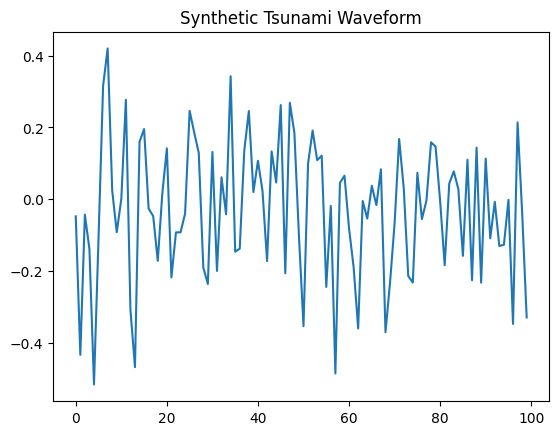

In [ ]:
# Ex.usage:- generate synthetic tsunami wave propagation maps
noise = torch.randn(32, 10)
cond = torch.randn(32, 5)  # earthquake magnitude, depth, lat, lon, etc.
gen = Generator(noise_dim=10, cond_dim=5, out_dim=100)
synthetic_wave = gen(noise, cond)

plt.plot(synthetic_wave[0].detach().numpy())
plt.title("Synthetic Tsunami Waveform")
plt.show()

In [ ]:
# Natural Language Advisory Generation (GeoGPT)

geo_gpt = pipeline("text-generation", model="google/flan-t5-base")

prompt = """
Generate an emergency tsunami alert for UAE:
Earthquake magnitude 7.8 near Oman trench.
Expected wave height: 3.5m, ETA: 45 minutes.
Provide advisory in English.
"""

alert = geo_gpt(prompt, max_length=100, do_sample=True)[0]['generated_text']
print(" AI-Generated Tsunami Alert \n")
print(alert)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu
The model 'T5ForConditionalGeneration' is not supported for text-generation. Supported models are ['PeftModelForCausalLM', 'ArceeForCausalLM', 'AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BitNetForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV2ForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'DogeForCausalLM', 'Dots1ForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'Ernie4_5ForCausalLM', 'Ernie4_5_MoeForCausalLM', 'Exaone4ForCausalLM', 'FalconForCausalLM', 'FalconH1ForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForC

 AI-Generated Tsunami Alert 


Generate an emergency tsunami alert for UAE:
Earthquake magnitude 7.8 near Oman trench.
Expected wave height: 3.5m, ETA: 45 minutes.
Provide advisory in English.



In [ ]:
#Dashboard / Visualization
#Streamlit or Plotly for demo.
#tsunami propagation map (how wave heights spread across a region).


import plotly.express as px

# Create heatmap of synthetic wave height propagation
wave_data = pd.DataFrame({
    "x": np.tile(np.arange(10), 10),
    "y": np.repeat(np.arange(10), 10),
    "wave_height": np.random.rand(100)
})

fig = px.density_heatmap(
    wave_data, x="x", y="y", z="wave_height",
    title="Synthetic Tsunami Propagation Map"
)
fig.show()